### Data Mining and Machine Learning

### Feature Selection in Supervised Classification
#### Edgar Acuna

#### Febrero 2019

##### Use of modules: feature_selection from scikit-learn, feature selection from Arizona State University , skrebate and Orange 


In [118]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math as m
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectPercentile, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Example 1: Diabetes dataset

In [119]:
url= "http://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names,header=None)
y=data['class']
X=data.iloc[:,0:8]

### I. Feature Selection by Visualization using boxplots

In [120]:
print(data.shape)
data.head()
#normalizando los datos
data1=data.drop('class',axis=1)
data1_norm=(data1 - data1.min()) / (data1.max() - data1.min())
data1_norm['class']=data['class']

(768, 9)


<Figure size 720x3600 with 0 Axes>

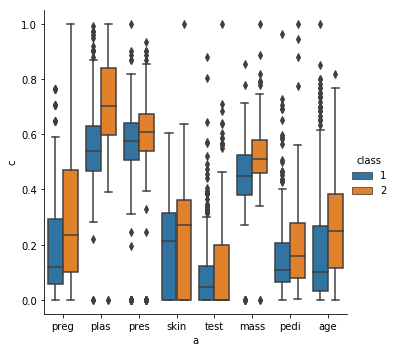

In [121]:
plt.figure(figsize=(10,50))
df_long = pd.melt(data1_norm, "class", var_name="a", value_name="c")
sns.factorplot("a", hue="class", y="c", data=df_long, kind="box")

Comment: From the boxplots we can see  that features: plas, age,preg,press and mass have boxplot not so overlaped

### II-Using the Chi-Square test  for choosing the best features
It is desirable to have discretizaed attributes and two classes. I do not recommend 
to use this method because the Chi-Square test is approximated and it is not robust.

In [122]:
y=data['class']
X=data.iloc[:,0:8]

In [123]:
# Funcion auxiliar para discretizar cualquier columna de un dataframe
def disc_col_ew(df,str,k,out):
    df1=df[str]
    bins=np.linspace(df1.min(), df1.max(),k)
    if out=="num":
        df1=pd.cut(df1,bins=bins,include_lowest=True, right=True,labels=False)
    else:
        bins[0]=float('-inf')
        bins[k-1]=float('inf')
        df1=pd.cut(df1,bins=bins,include_lowest=True, right=True)  
    return df1
# funcion auxiliar para determinar el numero optimo de intervalos segun la formula de scott
def nclass_scott(x):
    h=3.5*(np.var(x,ddof=1)**.5)*len(x)**(-.3333)
    intervals=m.ceil((max(x)-min(x))/h)
    return int(intervals)

In [124]:
#Funcion para discretizar todas las colunmnas de un dataframe
def disc_ew(df,out):
    name=df.columns.tolist()
    disc=pd.DataFrame()
    for name in df.columns.tolist():
        k=nclass_scott(df[name])
        disc[name]=disc_col_ew(df,name,k,out)
    return disc

In [125]:
#discretizando las columnas de la matriz predictora X de diabetes
diab_disc=disc_ew(X,out="num")

In [126]:
#choosing the best featires with Chi-square and scikit-learn
y1=y.as_matrix()
X1=diab_disc.as_matrix()
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X1, y1)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features= fit.transform(X1)
# Imprime los datos de las tres mejores features
print(features)

[105.387 120.206   2.87   10.086  59.232  42.746  62.639 115.924]
[[ 4 11  6]
 [ 0  6  2]
 [ 6 14  2]
 ...
 [ 3  9  1]
 [ 0 10  5]
 [ 0  7  0]]


Comentario: Las tres mejores variables con la prueba de Chi-square son plas, age y preg por tener el Chi-Square mas alto.

### III-Using the F test to find the best features  

Se puede usar la libreria sciki-learn o la libreria de la ASU

In [127]:
# Selecion  de Features usando los p-values de la F-test como score
# Aqui usamos scikit-learn y se selecciona el 30% de deatures con el mas alto score
selector = SelectPercentile(f_classif, percentile=30)
fit=selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
print(scores)
features= fit.transform(X)
# Imprime los datos de las tres mejores features
print(features)

[0.221 1.    0.027 0.034 0.084 0.378 0.14  0.253]
[[148.   33.6  50. ]
 [ 85.   26.6  31. ]
 [183.   23.3  32. ]
 ...
 [121.   26.2  30. ]
 [126.   30.1  47. ]
 [ 93.   30.4  23. ]]


Comentario: Las tres, mejores variables con la prueba de F son plas,mass y age

In [128]:
#Usando la libreria Feature selection de la ASU
#features, labels = X.values, data['class'].values
#X_train, X_test, y_train, y_test = train_test_split(features, labels)
from skfeature.function.statistical_based import f_score
scoref = f_score.f_score(X, y)
idx = f_score.feature_ranking(scoref)
print(scoref,idx)

[ 39.67  213.162   3.257   4.304  13.281  71.772  23.871  46.141] [1 5 7 0 6 4 3 2]


Comentario: las tres variables mas importantes con la prueba de F son: plas,mass y age

### IV- Usando Mutual Information (Entropia)

Libreria scikit-learn


In [129]:
# Univariate feature selection with Mutual Information
scores = mutual_info_classif(X,y)
scores /= scores.max()
print(scores)

[0.269 1.    0.134 0.335 0.28  0.746 0.073 0.471]



Comentario: Las tres variables usando el criterio de Mutual Information son: plas, mass y age

### V-Using ReliefF to select the best features 

Module: skrebate 

In [130]:
from skrebate import ReliefF
from sklearn.model_selection import train_test_split

df=data.drop('class',axis=1)
#Normalizando las predictoras
df_norm=(df - df.min()) / (df.max() - df.min())
features, labels = df_norm.values, data['class'].values

In [131]:
#X_train, X_test, y_train, y_test = train_test_split(features, labels)

fs = ReliefF(n_neighbors=10)
fs.fit(features, labels)
print(features.shape)
for feature_name, feature_score in zip(df.columns,fs.feature_importances_):
    print (feature_name, feature_score)

(768, 8)
preg 0.011557904411764679
plas 0.027526957705192593
pres 0.005626707650273222
skin 0.012511837121212118
test 0.004258551270685579
mass 0.015538065076999513
pedi 0.007962389695417026
age 0.009900173611111106


Comentario: las tres variables mas importantes con el ReliefF son: plas,mass y skin

ReliefF using the feature selection module form the ASU

In [133]:
from skfeature.function.similarity_based import reliefF
y1=y.as_matrix()
X1=X.as_matrix()
score_relief=reliefF.reliefF(X1,y1)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

[ 230.6   2752.6    521.8    875.4   1389.8    674.06    20.236  891.6  ] [1 4 7 3 5 2 0 6]


 Comentario: las tres variables mas importantes con el RelieF son: plas, test y age
 

Usando el Relief de Orange

In [134]:
import Orange
df = Orange.data.Table("c://PW-PR/diabetes.tab")
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=100 para updating de los pesos
print('Feature scores for best  features (scored individually):')
meas =Orange.preprocess.score.ReliefF(n_iterations=400,k_nearest=10)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)

Feature scores for best  features (scored individually):
0.013 preg
0.030 plas
0.006 pres
0.016 skin
0.004 test
0.020 mass
0.011 pedi
0.007 age


The best features are: plas, mass and skin.

#### Example 2:  Bupa dataset

In [135]:
# Usando el reliefF de la ASU
#load data
url= "http://academic.uprm.edu/eacuna/bupa.dat"
names = ['mcv', 'alkphos', 'sgpt', 'aspar', 'gammagt', 'drinks', 'class']
data = pd.read_table(url, names=names,header=None)
y=data['class']
X=data.iloc[:,0:6]
y1=y.as_matrix()
X1=X.as_matrix()
features, labels = X.values, data['class'].values

In [137]:
#X_train, X_test, y_train, y_test = train_test_split(features, labels)
score_relief=reliefF.reliefF(X1,y1)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

[ 48.4  78.2 276.2 142.2 209.6  90.5] [2 4 3 5 1 0]


El Relief de ASU recomienda sgpt, gammagt,aspar  como las mejores predictoras

In [138]:
fs = ReliefF(n_neighbors=10)
fs.fit(X_train, y_train)

for feature_name, feature_score in zip(data.columns,fs.feature_importances_):
    print (feature_name, feature_score)

mcv 0.0010403916768665868
alkphos -0.000802157061004381
sgpt 0.0038503003234252268
aspar 0.004706533776301219
gammagt 0.006291598152063266
drinks 0.0029263565891472897


El relielf de skrebate recomienda gammagt, aspar and sgpt 

### Example 3: Breast-cancer-Wisconsin

In [139]:
data = pd.read_table("c://PW-PR/breast-cancer-wisconsin.data", header=None,sep=",",na_values="?")
data=data.fillna(data.mean())
y=data.iloc[:,10]
X=data.iloc[:,1:10]
y1=y.as_matrix()
X1=X.as_matrix()
features, labels = X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(features, labels)

In [140]:
#usando Relief de la ASU
score_relief=reliefF.reliefF(X1,y1)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

[1338.2    806.4    789.6    677.2    404.2   1558.917  695.6    831.
  317.8  ] [5 0 7 1 2 6 3 4 8]


Comment:The best attributes are:6(Bare Nuclei),1 (Clump Thickness),8 (Normal. nucleoli),3 (Uniformity of Cell Shape),2  (Uniformity of Cell Size)

In [142]:
#Usando el Relief de Orange
import Orange
df = Orange.data.Table("breast-cancer-wisconsin-disc.tab")
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=400 para updating de los pesos
print('Feature scores for best ten features (scored individually):')
meas =Orange.preprocess.score.ReliefF(n_iterations=500,k_nearest=1)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)


Feature scores for best ten features (scored individually):
0.606 Clump Thickness
0.192 Uniformity of Cell Size
0.178 Uniformity of Cell Shape
0.190 Marginal Adhesion
0.154 Single Epithelial Cell Size
0.602 Bare Nuclei
0.528 Bland Chromatin
0.364 Normal Nucleoli
0.074 Mitoses


Comment:The best attributes are:6(Bare Nuclei),1 (Clump Thickness),7 (Bland Chromatin), 8 (Normal. nucleoli)

#### Example 4: Landsat Dataset

In [143]:
url='http://academic.uprm.edu/eacuna/landsat.txt'
data = pd.read_table(url, header=None,delim_whitespace=True)
y=data.iloc[:,36]
X=data.iloc[:,0:36]
y1=y.as_matrix()
X1=X.as_matrix()
features, labels = X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(features, labels)

### Using Relief from skfeature (ASU)

In [144]:
#usando Relief de la ASU
score_relief=reliefF.reliefF(X_train,y_train)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

[ 976917.152 1292891.619  906229.487 1071693.564  909766.879 1157467.244
  830073.224  994363.016  964984.972 1289774.198  859437.259 1148954.461
 1041899.071 1372314.299  891134.2   1101441.225  974973.239 1271261.7
  808720.221  976452.953 1011435.426 1346047.531  782803.463 1042118.782
 1050978.736 1412031.808  911416.433 1125161.371  959316.257 1336772.086
  822559.414  975436.07   985263.459 1371694.208  842477.69  1089131.571] [25 13 33 21 29  1  9 17  5 11 27 15 35  3 24 23 12 20  7 32  0 19 31 16
  8 28 26  4  2 14 10 34  6 30 18 22]


In [ ]:
Comment:The best attributes are:26,14,34,22,30,2,10,18,6,28

### Using Relief from Orange

In [148]:
#Usando el Relief de Orange
import Orange
df = Orange.data.Table("c://PW-PR/landsat.tab")
print('Feature scores for best ten features (scored individually):')
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=2000 para updating de los pesos
meas =Orange.preprocess.score.ReliefF(n_iterations=2000,k_nearest=10)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)


Feature scores for best ten features (scored individually):
0.114 a1
0.087 a2
0.075 a3
0.066 a4
0.115 a5
0.077 a6
0.055 a7
0.057 a8
0.111 a9
0.084 a10
0.055 a11
0.065 a12
0.128 a13
0.100 a14
0.071 a15
0.076 a16
0.123 a17
0.096 a18
0.071 a19
0.066 a20
0.120 a21
0.091 a22
0.057 a23
0.066 a24
0.123 a25
0.096 a26
0.077 a27
0.071 a28
0.116 a29
0.096 a30
0.062 a31
0.062 a32
0.119 a33
0.090 a34
0.061 a35
0.064 a36


Comment:The best attributes are:a13,a1,a17,a21,a25,a29,a33,a5,a9